In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/test-dataset/test (2).csv
/kaggle/input/train-dataset/train.csv


In [2]:
# import the Data Set
Sales_train = pd.read_csv("/kaggle/input/train-dataset/train.csv")
Sales_train.head(10)

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity
0,5/22/2023,57mm,freezers available,outstation,outlet_code_3254,95
1,5/29/2023,8mm,freezers available,outstation,outlet_code_1859,107
2,5/8/2023,170.57mm,freezers available,outstation,outlet_code_4176,83
3,5/22/2023,37mm,freezers available,outstation,outlet_code_1459,106
4,3/27/2023,7mm,freezers available,outstation,outlet_code_38,43
5,4/10/2023,0mm,freezers available,outstation,outlet_code_2006,56
6,3/20/2023,143.31mm,freezers available,outstation,outlet_code_3795,56
7,3/20/2023,138.99mm,freezers available,outstation,outlet_code_2892,53
8,1/2/2023,14mm,freezers available,outstation,outlet_code_1738,59
9,4/3/2023,33mm,freezers available,outstation,outlet_code_2189,41


In [3]:
# Find the Total Number of rows and Columns
Sales_train.shape

(113400, 6)

In [4]:
# Find the data type for each column
Sales_train.dtypes

week_start_date      object
expected_rainfall    object
freezer_status       object
outlet_region        object
outlet_code          object
sales_quantity        int64
dtype: object

In [5]:
# Checking Missing Values 
Sales_train.isnull().sum()

week_start_date      0
expected_rainfall    0
freezer_status       0
outlet_region        0
outlet_code          0
sales_quantity       0
dtype: int64

In [6]:
# Covert the type of Week_Start_date column into date type
Sales_train["week_start_date"] = pd.to_datetime(Sales_train['week_start_date'])

Sales_train.dtypes

week_start_date      datetime64[ns]
expected_rainfall            object
freezer_status               object
outlet_region                object
outlet_code                  object
sales_quantity                int64
dtype: object

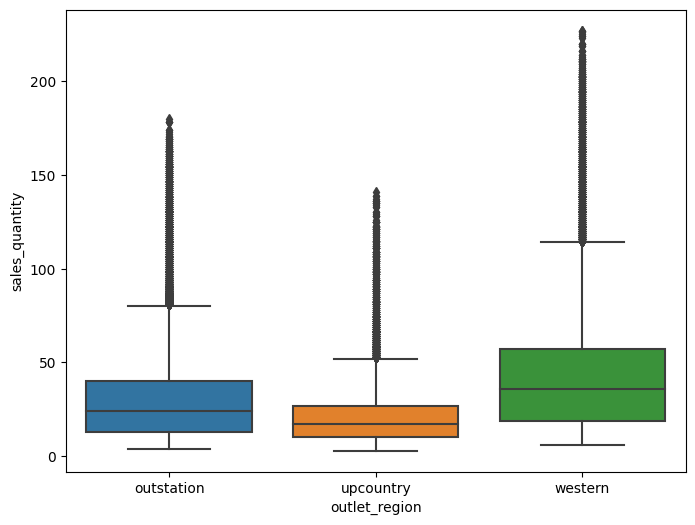

In [7]:
# Draw the Boxplot Sales_quantity vs Outlet_region
plt.figure(figsize=(8,6))
sns.boxplot(y="sales_quantity",x="outlet_region",data=Sales_train)
plt.show()

In [8]:
# Removing OutLiers
Q1 = Sales_train['sales_quantity'].quantile(0.25)
Q3 = Sales_train['sales_quantity'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#(Sales_train['sales_quantity'] < (Q1 - 1.5 * IQR)) |(Sales_train['sales_quantity'] > (Q3 + 1.5 * IQR))

out_rows=((Sales_train['sales_quantity']< (Q1 - 1.5 * IQR)) |(Sales_train['sales_quantity']> (Q3 + 1.5 * IQR)))

Sales_out=Sales_train[~out_rows]
Sales_out.head()

30.0


,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity
2,2023-05-08,170.57mm,freezers available,outstation,outlet_code_4176,83
4,2023-03-27,7mm,freezers available,outstation,outlet_code_38,43
5,2023-04-10,0mm,freezers available,outstation,outlet_code_2006,56
6,2023-03-20,143.31mm,freezers available,outstation,outlet_code_3795,56
7,2023-03-20,138.99mm,freezers available,outstation,outlet_code_2892,53


In [9]:
Sales_out.shape

(107814, 6)

In [10]:
#add a 'week' column to the dataset for further analysis
Sales_out['Week'] = Sales_out['week_start_date'].dt.isocalendar().week

/tmp/ipykernel_19/3244993922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_out['Week'] = Sales_out['week_start_date'].dt.isocalendar().week


In [11]:
Sales_out.head(6)

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity,Week
2,2023-05-08,170.57mm,freezers available,outstation,outlet_code_4176,83,19
4,2023-03-27,7mm,freezers available,outstation,outlet_code_38,43,13
5,2023-04-10,0mm,freezers available,outstation,outlet_code_2006,56,15
6,2023-03-20,143.31mm,freezers available,outstation,outlet_code_3795,56,12
7,2023-03-20,138.99mm,freezers available,outstation,outlet_code_2892,53,12
8,2023-01-02,14mm,freezers available,outstation,outlet_code_1738,59,1


In [12]:
Sales_out.describe()

,week_start_date,sales_quantity,Week
count,107814,107814.000000,107814.0
mean,2023-03-30 11:22:08.087261440,29.291576,13.496244
min,2023-01-02 00:00:00,3.000000,1.0
25%,2023-02-13 00:00:00,13.000000,7.0
50%,2023-03-27 00:00:00,24.000000,13.0
75%,2023-05-15 00:00:00,41.000000,20.0
max,2023-07-03 00:00:00,89.000000,27.0
std,NaN,19.868500,7.626234


In [13]:
# Find the average sales for each Date
Avg = Sales_out.groupby('week_start_date')['sales_quantity'].mean()
Avg

week_start_date
2023-01-02    22.536190
2023-01-09    22.789286
2023-01-16    22.845952
2023-01-23    22.201190
2023-01-30    22.836190
2023-02-06    23.308810
2023-02-13    23.314762
2023-02-20    23.292143
2023-02-27    22.823571
2023-03-06    23.466905
2023-03-13    23.400000
2023-03-20    25.381665
2023-03-27    25.577381
2023-04-03    27.338267
2023-04-10    28.547728
2023-04-17    28.325354
2023-04-24    31.459815
2023-05-01    32.984871
2023-05-08    32.017627
2023-05-15    34.477073
2023-05-22    37.413793
2023-05-29    39.626984
2023-06-05    36.583170
2023-06-12    41.927401
2023-06-19    43.291813
2023-06-26    43.793660
2023-07-03    43.963921
Name: sales_quantity, dtype: float64

In [14]:
# Merge the Average Sales Column
Sales_out['AverageSales'] = Sales_out['week_start_date'].map(Avg)
Sales_out

/tmp/ipykernel_19/2482711756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_out['AverageSales'] = Sales_out['week_start_date'].map(Avg)


,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity,Week,AverageSales
2,2023-05-08,170.57mm,freezers available,outstation,outlet_code_4176,83,19,32.017627
4,2023-03-27,7mm,freezers available,outstation,outlet_code_38,43,13,25.577381
5,2023-04-10,0mm,freezers available,outstation,outlet_code_2006,56,15,28.547728
6,2023-03-20,143.31mm,freezers available,outstation,outlet_code_3795,56,12,25.381665
7,2023-03-20,138.99mm,freezers available,outstation,outlet_code_2892,53,12,25.381665
...,...,...,...,...,...,...,...,...
113395,2023-04-24,61mm,freezers available,western,outlet_code_2946,27,17,31.459815
113396,2023-02-20,10mm,freezers available,western,outlet_code_3671,36,8,23.292143
113397,2023-06-05,98.28mm,freezers available,western,outlet_code_3671,76,23,36.583170
113398,2023-06-05,120.46mm,freezers available,western,outlet_code_2618,76,23,36.583170


In [15]:
Sales_out.isnull().sum()

week_start_date      0
expected_rainfall    0
freezer_status       0
outlet_region        0
outlet_code          0
sales_quantity       0
Week                 0
AverageSales         0
dtype: int64

In [16]:
Outstation_AvgSum = Sales_out[Sales_out['outlet_region'] == 'outstation']['AverageSales'].sum()
Western_AvgSum = Sales_out[Sales_out['outlet_region'] == 'western']['AverageSales'].sum()
Upcountry_AvgSum = Sales_out[Sales_out['outlet_region'] == 'upcountry']['AverageSales'].sum()

Region = ['outstation','western','upcountry']
Average =[Outstation_AvgSum,Western_AvgSum,Upcountry_AvgSum]

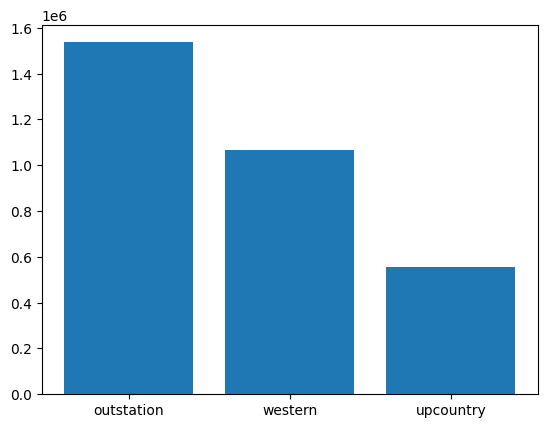

In [17]:
# Draw the the barchart for each outlet_region vs weekly average sales
plt.bar(Region,Average)
plt.show()

In [18]:
TotalSales = Sales_out.groupby('week_start_date')['sales_quantity'].sum()
TotalSales

week_start_date
2023-01-02     94652
2023-01-09     95715
2023-01-16     95953
2023-01-23     93245
2023-01-30     95912
2023-02-06     97897
2023-02-13     97922
2023-02-20     97827
2023-02-27     95859
2023-03-06     98561
2023-03-13     98280
2023-03-20    105207
2023-03-27    107425
2023-04-03    114520
2023-04-10    118730
2023-04-17    115964
2023-04-24    129174
2023-05-01    135172
2023-05-08    128967
2023-05-15    137598
2023-05-22    145390
2023-05-29    149790
2023-06-05    130419
2023-06-12    148423
2023-06-19    148058
2023-06-26    143687
2023-07-03    137695
Name: sales_quantity, dtype: int64

In [19]:
Sales_out['TotalSales'] = Sales_out['week_start_date'].map(TotalSales)
Sales_out

/tmp/ipykernel_19/545124655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_out['TotalSales'] = Sales_out['week_start_date'].map(TotalSales)


,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity,Week,AverageSales,TotalSales
2,2023-05-08,170.57mm,freezers available,outstation,outlet_code_4176,83,19,32.017627,128967
4,2023-03-27,7mm,freezers available,outstation,outlet_code_38,43,13,25.577381,107425
5,2023-04-10,0mm,freezers available,outstation,outlet_code_2006,56,15,28.547728,118730
6,2023-03-20,143.31mm,freezers available,outstation,outlet_code_3795,56,12,25.381665,105207
7,2023-03-20,138.99mm,freezers available,outstation,outlet_code_2892,53,12,25.381665,105207
...,...,...,...,...,...,...,...,...,...
113395,2023-04-24,61mm,freezers available,western,outlet_code_2946,27,17,31.459815,129174
113396,2023-02-20,10mm,freezers available,western,outlet_code_3671,36,8,23.292143,97827
113397,2023-06-05,98.28mm,freezers available,western,outlet_code_3671,76,23,36.583170,130419
113398,2023-06-05,120.46mm,freezers available,western,outlet_code_2618,76,23,36.583170,130419


In [20]:
# Change type for expected rainfall to float
Sales_out['expected_rainfall'] = Sales_out['expected_rainfall'].str.extract(r'(\d+)').astype(float)

/tmp/ipykernel_19/2680309944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_out['expected_rainfall'] = Sales_out['expected_rainfall'].str.extract(r'(\d+)').astype(float)


In [21]:
Sales_out.head()

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity,Week,AverageSales,TotalSales
2,2023-05-08,170.0,freezers available,outstation,outlet_code_4176,83,19,32.017627,128967
4,2023-03-27,7.0,freezers available,outstation,outlet_code_38,43,13,25.577381,107425
5,2023-04-10,0.0,freezers available,outstation,outlet_code_2006,56,15,28.547728,118730
6,2023-03-20,143.0,freezers available,outstation,outlet_code_3795,56,12,25.381665,105207
7,2023-03-20,138.0,freezers available,outstation,outlet_code_2892,53,12,25.381665,105207


In [22]:
# Correlation between expected_rainfall vs TotalSales
correlation = Sales_out['expected_rainfall'].corr(Sales_out['TotalSales'])
correlation

-0.10097649991353731

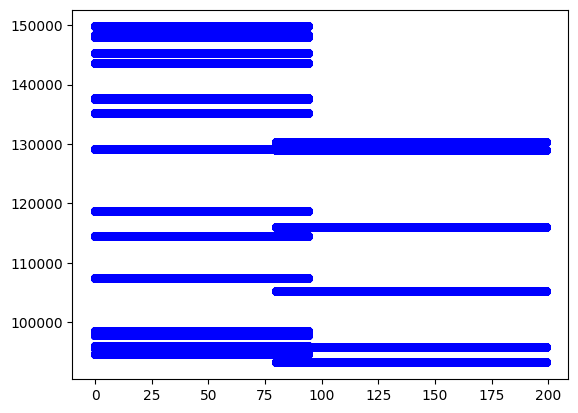

In [23]:
# scatter plot between expected_rainfall vs TotalSales
plt.scatter(Sales_out['expected_rainfall'],Sales_out['TotalSales'],color='blue', marker='o',linewidths=0.2)
plt.show()

/tmp/ipykernel_19/871430281.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=weekly_sales, x='Week', y='sales_quantity', hue='outlet_region', ci=None)


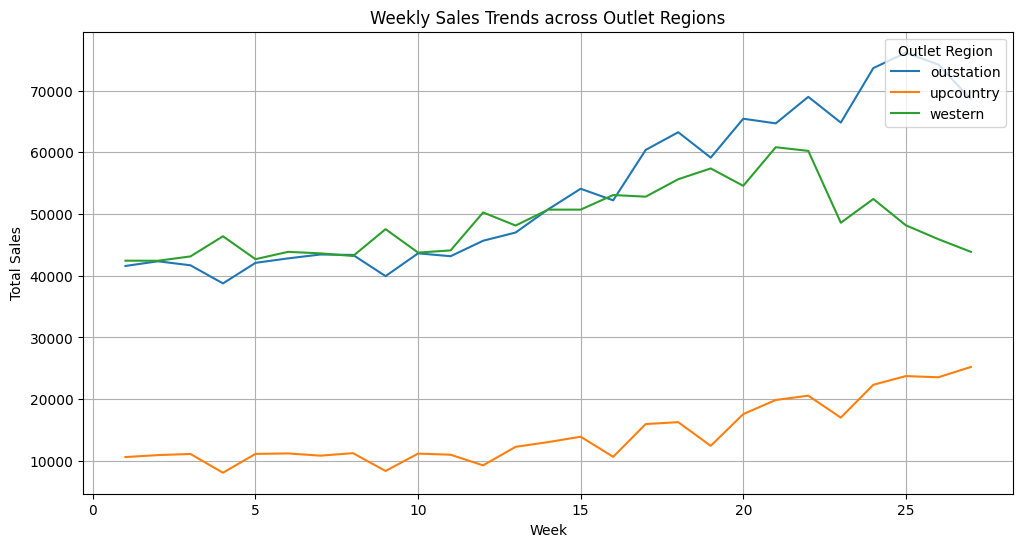

In [24]:
# Group by 'Outlet Region', 'Year', and 'Week' to get weekly sales
weekly_sales = Sales_out.groupby(['outlet_region','Week'])['sales_quantity'].sum().reset_index()


# Plotting weekly sales trends for each outlet region
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x='Week', y='sales_quantity', hue='outlet_region', ci=None)
plt.title('Weekly Sales Trends across Outlet Regions')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.legend(title='Outlet Region', loc='upper right')
plt.grid(True)
plt.show()

In [25]:
Sales_out

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity,Week,AverageSales,TotalSales
2,2023-05-08,170.0,freezers available,outstation,outlet_code_4176,83,19,32.017627,128967
4,2023-03-27,7.0,freezers available,outstation,outlet_code_38,43,13,25.577381,107425
5,2023-04-10,0.0,freezers available,outstation,outlet_code_2006,56,15,28.547728,118730
6,2023-03-20,143.0,freezers available,outstation,outlet_code_3795,56,12,25.381665,105207
7,2023-03-20,138.0,freezers available,outstation,outlet_code_2892,53,12,25.381665,105207
...,...,...,...,...,...,...,...,...,...
113395,2023-04-24,61.0,freezers available,western,outlet_code_2946,27,17,31.459815,129174
113396,2023-02-20,10.0,freezers available,western,outlet_code_3671,36,8,23.292143,97827
113397,2023-06-05,98.0,freezers available,western,outlet_code_3671,76,23,36.583170,130419
113398,2023-06-05,120.0,freezers available,western,outlet_code_2618,76,23,36.583170,130419


In [26]:
# Extract the sales_quantity data groupby week_start_date with outlet_code 
TotalSales_Out = Sales_out.groupby(['week_start_date','outlet_code'])['sales_quantity'].sum().reset_index()

In [27]:
TotalSales_Out

,week_start_date,outlet_code,sales_quantity
0,2023-01-02,outlet_code_1,14
1,2023-01-02,outlet_code_10,70
2,2023-01-02,outlet_code_100,30
3,2023-01-02,outlet_code_1000,6
4,2023-01-02,outlet_code_1001,9
...,...,...,...
107809,2023-07-03,outlet_code_992,39
107810,2023-07-03,outlet_code_993,41
107811,2023-07-03,outlet_code_994,45
107812,2023-07-03,outlet_code_996,53


In [28]:
# Covert the data set to timeseries data set
Sales_timeOut_series = TotalSales_Out.set_index(['week_start_date','outlet_code'])['sales_quantity'].reset_index()
Sales_timeOut_series

,week_start_date,outlet_code,sales_quantity
0,2023-01-02,outlet_code_1,14
1,2023-01-02,outlet_code_10,70
2,2023-01-02,outlet_code_100,30
3,2023-01-02,outlet_code_1000,6
4,2023-01-02,outlet_code_1001,9
...,...,...,...
107809,2023-07-03,outlet_code_992,39
107810,2023-07-03,outlet_code_993,41
107811,2023-07-03,outlet_code_994,45
107812,2023-07-03,outlet_code_996,53


In [29]:
# Check the series stationary or not
result = adfuller(TotalSales_Out['sales_quantity'])

# Extract and print test statistic and p-value
test_statistic, p_value, _, _, _, _ = result
print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')

Test Statistic: -12.518952876905693
P-value: 2.5738754298714466e-23


In [30]:
# Make it series is stationary
Sales_differentSeries_1 = Sales_timeOut_series.sales_quantity.diff().dropna().reset_index()
Sales_differentSeries_1

,index,sales_quantity
0,1,56.0
1,2,-40.0
2,3,-24.0
3,4,3.0
4,5,20.0
...,...,...
107808,107809,33.0
107809,107810,2.0
107810,107811,4.0
107811,107812,8.0


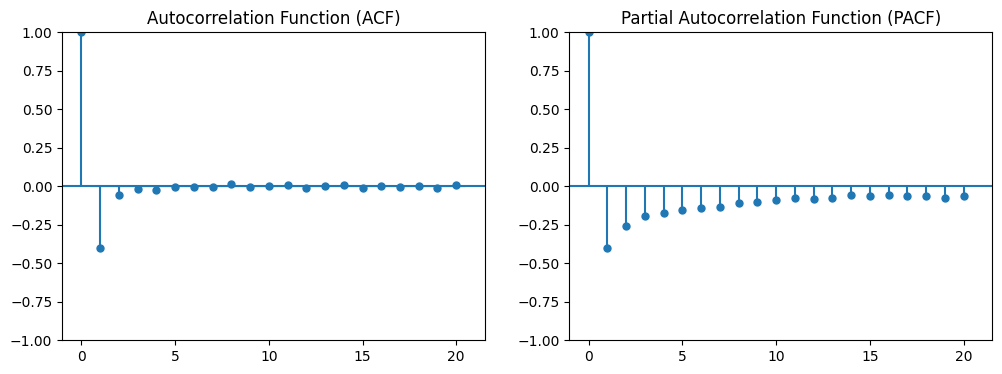

In [31]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot
plot_acf(Sales_differentSeries_1['sales_quantity'], lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(Sales_differentSeries_1['sales_quantity'], lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [32]:
# Fitting the Model
p, d, q = 0, 1, 1
model = ARIMA(Sales_timeOut_series.sales_quantity, order=(p, d, q))
results_Out = model.fit()
print(results_Out.summary())

                               SARIMAX Results                                
Dep. Variable:         sales_quantity   No. Observations:               107814
Model:                 ARIMA(0, 1, 1)   Log Likelihood             -467660.909
Date:                Sat, 02 Dec 2023   AIC                         935325.819
Time:                        19:09:19   BIC                         935344.995
Sample:                             0   HQIC                        935331.619
                             - 107814                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985      0.000  -6558.307      0.000      -0.999      -0.998
sigma2       342.8880      1.497    229.063      0.000     339.954     345.822
Ljung-Box (L1) (Q):                5091.85   Jarque-

In [33]:
# Import the Test Data Set
test  = pd.read_csv('/kaggle/input/test-dataset/test (2).csv')
test.head()

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity
0,7/10/2023,144.6mm,freezers available,outstation,outlet_code_1,NaN
1,7/10/2023,114.6mm,freezers available,western,outlet_code_10,NaN
2,7/10/2023,135.48mm,freezers available,western,outlet_code_100,NaN
3,7/10/2023,135.53mm,no freezers available,outstation,outlet_code_1000,NaN
4,7/10/2023,167.37mm,no freezers available,outstation,outlet_code_1001,NaN


In [34]:
# Changing the type of expected_rainfall and week_start_date
test['expected_rainfall'] = test['expected_rainfall'].str.extract(r'(\d+)').astype(float)
test["week_start_date"] = pd.to_datetime(test['week_start_date'])

In [35]:
test.head()

,week_start_date,expected_rainfall,freezer_status,outlet_region,outlet_code,sales_quantity
0,2023-07-10,144.0,freezers available,outstation,outlet_code_1,NaN
1,2023-07-10,114.0,freezers available,western,outlet_code_10,NaN
2,2023-07-10,135.0,freezers available,western,outlet_code_100,NaN
3,2023-07-10,135.0,no freezers available,outstation,outlet_code_1000,NaN
4,2023-07-10,167.0,no freezers available,outstation,outlet_code_1001,NaN


In [36]:
test['sales_quantity'].fillna(0.0)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4195    0.0
4196    0.0
4197    0.0
4198    0.0
4199    0.0
Name: sales_quantity, Length: 4200, dtype: float64

In [37]:
TestSales_Out = test.groupby(['week_start_date','outlet_code'])['sales_quantity'].sum().reset_index()

In [38]:
TestSales_Out

,week_start_date,outlet_code,sales_quantity
0,2023-07-10,outlet_code_1,0.0
1,2023-07-10,outlet_code_10,0.0
2,2023-07-10,outlet_code_100,0.0
3,2023-07-10,outlet_code_1000,0.0
4,2023-07-10,outlet_code_1001,0.0
...,...,...,...
4195,2023-07-10,outlet_code_995,0.0
4196,2023-07-10,outlet_code_996,0.0
4197,2023-07-10,outlet_code_997,0.0
4198,2023-07-10,outlet_code_998,0.0


In [39]:
# Predict the future Sales
future_steps = len(TestSales_Out)
predictions = results_Out.predict(0, len(TestSales_Out.sales_quantity)-1)
predictions = predictions.astype(int)

#future plot
# Create a DataFrame with the original data and predictions
forecast_2 = pd.DataFrame({'outlet_code':TestSales_Out.outlet_code, 'predicted_sales': predictions})

In [40]:
forecast_2

,outlet_code,predicted_sales
0,outlet_code_1,0
1,outlet_code_10,13
2,outlet_code_100,41
3,outlet_code_1000,37
4,outlet_code_1001,29
...,...,...
4195,outlet_code_995,22
4196,outlet_code_996,22
4197,outlet_code_997,22
4198,outlet_code_998,22


In [41]:
ActualSales = Sales_timeOut_series.groupby('outlet_code')['sales_quantity'].sum().reset_index()

In [42]:
ActualSales

,outlet_code,sales_quantity
0,outlet_code_1,884
1,outlet_code_10,974
2,outlet_code_100,1199
3,outlet_code_1000,244
4,outlet_code_1001,252
...,...,...
4195,outlet_code_995,1016
4196,outlet_code_996,1043
4197,outlet_code_997,1236
4198,outlet_code_998,936


In [43]:
# Calculate Difference between ActualSales and Predictions for each outlet_code
Diff= np.abs(ActualSales['sales_quantity']- forecast_2['predicted_sales'])

In [44]:
# Calculate MAPE
MAPE = Diff.sum() / ActualSales['sales_quantity'].sum()

In [45]:
MAPE

0.9707809459152221

In [46]:
forecast_2.set_index('outlet_code')

,predicted_sales
outlet_code,
outlet_code_1,0
outlet_code_10,13
outlet_code_100,41
outlet_code_1000,37
outlet_code_1001,29
...,...
outlet_code_995,22
outlet_code_996,22
outlet_code_997,22


In [47]:
forecast_2.to_csv("FinalForecast.csv")